In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = r"C:\Pictures\Dataset\TrainingSet" # Path to training dataset

CATEGORIES = ["RGB images score 1", "RGB images score 2", "RGB images score 3"]

for category in CATEGORIES:  # Score 1 to Score 3
    path = os.path.join(DATADIR,category)  # create path to images
    for img in os.listdir(path):  # iterate over each image
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
        RGB_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img_array)  # graph it
        plt.show()  # display

        break  
    break 

<Figure size 640x480 with 1 Axes>

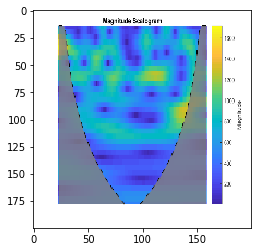

In [2]:
IMG_SIZE = 200 # define image size

new_array = cv2.resize(RGB_img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [3]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do Score 1 to Score 3

        path = os.path.join(DATADIR,category)  # create path to images
        class_num = CATEGORIES.index(category)  # get the classification (0/1/2). 0=Score 1, 1=Score 2, 2=Score 3

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to chosen data size
                training_data.append([new_array, class_num])  # add to training_data
            except Exception as e:  
                pass
            #except OSError as e:
            #    print("Corrupted images", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 2787/2787 [00:24<00:00, 115.93it/s]


9441


In [4]:
import random
import pickle

random.shuffle(training_data)

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)


pickle_out = open("X_example.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y_example.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime
import time
import pickle


pickle_in = open("X_example.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y_example.pickle","rb")
y = pickle.load(pickle_in)

X = X *1.0/100 - 1.0 

dense_layers = [1]
layer_sizes = [32]
conv_layers = [4]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()
            
            model.add(Conv2D(layer_size, kernel_size=(5, 5), strides=(1, 1),activation='relu',input_shape=X.shape[1:]))
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
            
            for a in range(conv_layer-1):
                model.add(Conv2D(layer_size,(5, 5), activation='relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
            
            model.add(Flatten())
            
            for b in range(dense_layer):
                model.add(Dense(10, activation='relu'))
                model.add(Dropout(0.1))
            
            
            model.add(Dense(3, activation='softmax'))
            
            tensorboard = TensorBoard(log_dir="C:\\tmp\\logs\\example\\{}".format(NAME))
            #earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)
            #adam = tf.keras.optimizers.Adam(lr=0.01)
            
            model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
            
            print(model.summary())
            
            model.fit(X, y, batch_size=10, epochs=20, validation_split=0.1, verbose=1, callbacks=[tensorboard])
            
model.save('example.model')
            
print("Run the command line on anaconda prompt:\n" \
          "--> tensorboard --logdir=/tmp/logs/ --host localhost --port 8088 " \
          "\nThen open http://localhost:8088/ into your web browser")

W0122 19:28:13.150898 15232 deprecation.py:506] From C:\Users\admin\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


4-conv-32-nodes-1-dense-1579692493
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os

path = r"C:\Pictures\Dataset\PredictionSet" # Path to prediction set
CATEGORIES = ["RGB images score 1", "RGB images score 2", "RGB images score 3"]

def prepare(filepath):
    IMG_SIZE = 200  
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    RGB_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    new_array = cv2.resize(RGB_img_array, (IMG_SIZE, IMG_SIZE))
    final_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    return final_array *1.0/100 - 1.0 
   
    
model = tf.keras.models.load_model("example.model")

for filename in os.listdir(path):
    prediction = model.predict([prepare(os.path.join(path,filename))])
    
    print(filename)

    print(prediction[0])

    print(CATEGORIES[int(np.argmax(prediction[0]))])

    print("\n")

W1028 21:02:17.449982  3148 deprecation.py:506] From C:\Users\admin\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1028 21:02:17.451976  3148 deprecation.py:506] From C:\Users\admin\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1028 21:02:17.452974  3148 deprecation.py:506] From C:\Users\admin\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.op